In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('DataSets/ice_cream.csv')
print(df.isnull().sum())
df.info()
df.head()

date    0
sale    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    577 non-null    object 
 1   sale    577 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.1+ KB


,date,sale
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [3]:
#converting Month in proper format (1956-01)
df['monthYear'] = pd.to_datetime(df['date'])
# df.info()
df.set_index('monthYear', inplace=True)
df.head()

,date,sale
monthYear,,
1972-01-01,1972-01-01,59.9622
1972-02-01,1972-02-01,67.0605
1972-03-01,1972-03-01,74.2350
1972-04-01,1972-04-01,78.1120
1972-05-01,1972-05-01,84.7636


In [5]:
df.drop('date', axis=1)

,sale
monthYear,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-09-01,100.1741
2019-10-01,90.1684
2019-11-01,79.7223


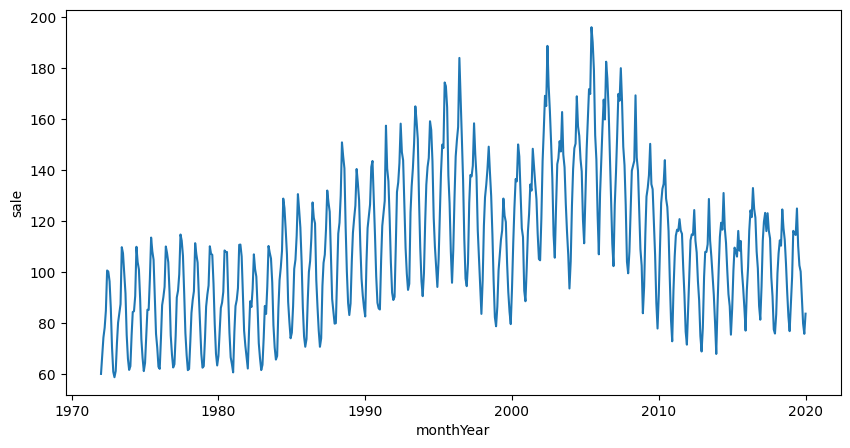

In [7]:
#visulize time serise
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x=df.index, y=df.sale)
plt.show()

C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_18148\2772043835.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


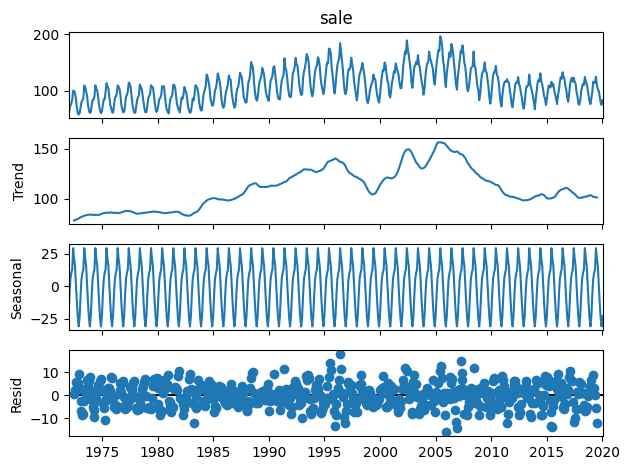

In [8]:
# checking for seasonality and trend by doing decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df.sale)
plot = decomposition.plot()
plot.show()

(np.float64(-1.758008775510543), np.float64(0.40149928994076167), 19, 557, {'1%': np.float64(-3.4421447800270673), '5%': np.float64(-2.8667429272780858), '10%': np.float64(-2.5695409929766093)}, np.float64(3284.760793628813))
ADF value: 0.4015
time serise is not stationary(H0 not accept)


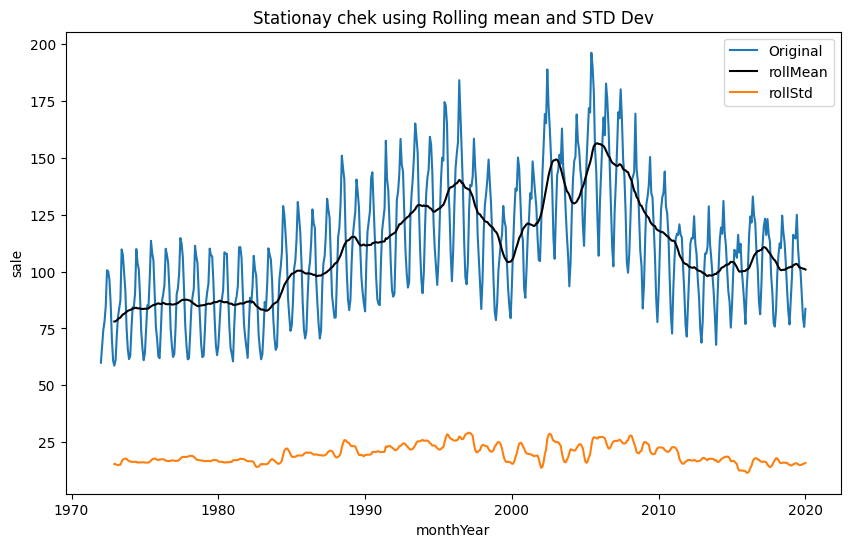

In [10]:
#cheking wheater time serise is stationary or not
#rolling mean anad std dev for 12 month
from statsmodels.tsa.stattools import adfuller
def test_stationarity(dataframe, col):
    df['rollMean'] = dataframe[col].rolling(window=12).mean()
    df['rollStd'] = dataframe[col].rolling(window=12).std()

    adf_result = adfuller(dataframe[col])
    print(adf_result)
    p_value = adf_result[1]

    print(f"ADF value: {p_value:.4f}")

    if p_value < 0.05:
        print("time serise is stationary(H0 accept)")
    else:
        print("time serise is not stationary(H0 not accept)")

      #plot original serise with rolling mean and std
    plt.figure(figsize=(10,6))
    sns.lineplot(data = df, x=df.index, y=df.sale, label = 'Original')
    sns.lineplot(data = df, x=df.index, y=df.rollMean, label = 'rollMean', color = 'black')
    sns.lineplot(data = df, x=df.index, y=df.rollStd, label = 'rollStd')
    plt.title("Stationay chek using Rolling mean and STD Dev")
    plt.show()
    # print(df.tail())

test_stationarity(df, 'sale')


(np.float64(-6.627957542548451), np.float64(5.8116215620546845e-09), 19, 556, {'1%': np.float64(-3.4421660928041633), '5%': np.float64(-2.8667523104859627), '10%': np.float64(-2.56954599309042)}, np.float64(3279.405080003882))
ADF value: 0.0000
time serise is stationary(H0 accept)


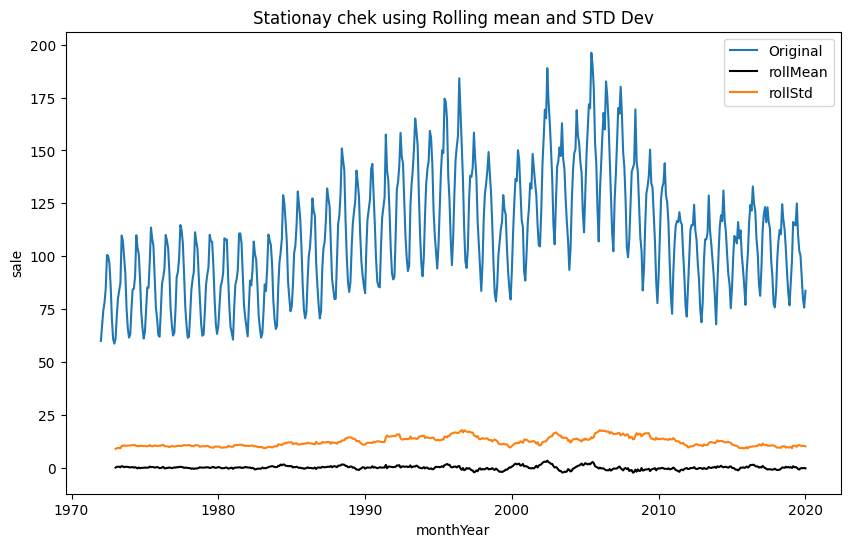

In [15]:
ice_df = df[['sale']].copy()
ice_df.head()

ice_df['shift'] = ice_df.sale.shift(1)
ice_df['shiftDiff'] = ice_df['sale'] - ice_df['shift']

test_stationarity(ice_df.dropna(), 'shiftDiff')

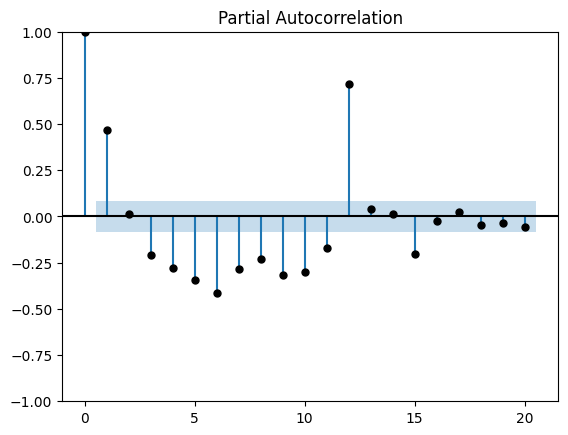

In [16]:
#ARIMA 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(ice_df['shiftDiff'].dropna(), lags=20, color = 'black')
plt.show()

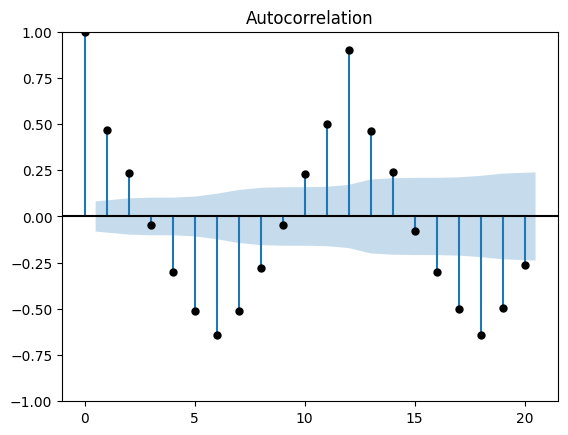

In [17]:

plot_acf(ice_df['shiftDiff'].dropna(), lags=20, color = 'black')
plt.show()

In [18]:
#Build ARIMA Model
train = ice_df[:round(len(ice_df) * 70/100)]
print(train.tail())

                sale     shift  shiftDiff
monthYear                                
2005-04-01  171.8314  159.2750    12.5564
2005-05-01  169.9522  171.8314    -1.8792
2005-06-01  196.1737  169.9522    26.2215
2005-07-01  190.2501  196.1737    -5.9236
2005-08-01  179.2849  190.2501   -10.9652


In [19]:
test = ice_df[round(len(ice_df) * 70/100):]
print(test.tail())

                sale     shift  shiftDiff
monthYear                                
2019-09-01  100.1741  102.6085    -2.4344
2019-10-01   90.1684  100.1741   -10.0057
2019-11-01   79.7223   90.1684   -10.4461
2019-12-01   75.7094   79.7223    -4.0129
2020-01-01   83.6290   75.7094     7.9196


In [21]:
model = ARIMA(train['sale'], order=(1,1,1))
model_fit = model.fit()
prediction = model_fit.predict(start=test.index[0], end=test.index[-1])
ice_df['arimaPred'] = prediction
ice_df['PredDiff'] = ice_df['arimaPred'] - ice_df['sale']
# print(ice_df.tail(30))

c:\Users\dbda.STUDENTSDC\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dbda.STUDENTSDC\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dbda.STUDENTSDC\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


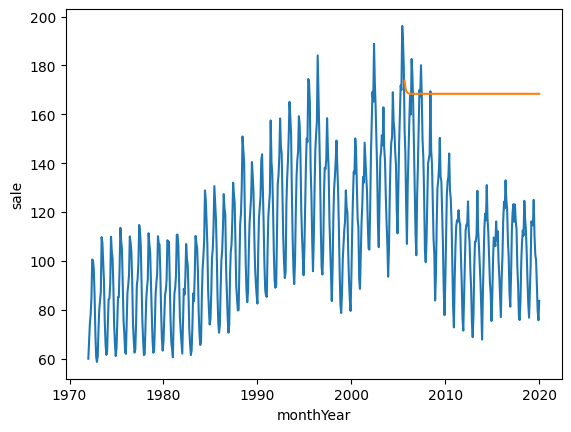

In [22]:
#Plotting the  ARIMA
sns.lineplot(data=ice_df, x = ice_df.index, y='sale')
sns.lineplot(data=ice_df, x = ice_df.index, y='arimaPred')
plt.show()

In [31]:
#SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarimax = SARIMAX(train['sale'],order=(11,0,0), seasonal_order=(1,0,0,12))
model_fit = model_sarimax.fit()
prediction_s = model_fit.predict(start=test.index[0], end=test.index[-1])
ice_df['sarimaxPred'] = prediction_s
# air_df['PredDiff'] = air_df['arimaPred'] - air_df['sale']


c:\Users\dbda.STUDENTSDC\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dbda.STUDENTSDC\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dbda.STUDENTSDC\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dbda.STUDENTSDC\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parame

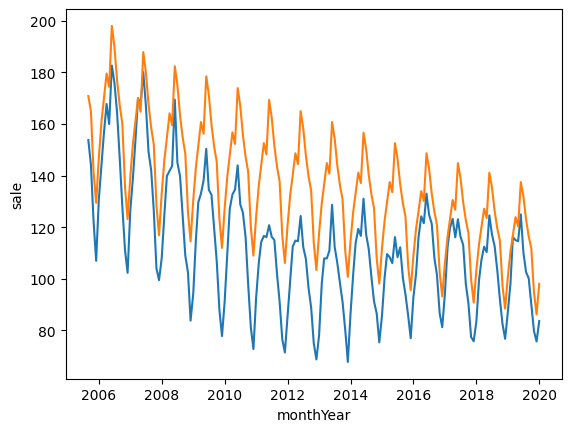

In [32]:
#Plotting the  ARIMA
sns.lineplot(data=ice_df, x = ice_df.index, y='sale')
sns.lineplot(data=ice_df, x = ice_df.index, y='sarimaxPred')
plt.show()

In [33]:
# sarimax Evaluation
ice_df = ice_df.dropna()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(ice_df['sale'], ice_df['sarimaxPred'])
rmae = mean_squared_error(ice_df['sale'], ice_df['sarimaxPred'])
r2 = r2_score(ice_df['sale'], ice_df['sarimaxPred'])

print(f"ARMIS MAE: {mae}, RMAE: {rmae}, r2: {r2}")

ARMIS MAE: 24.022655035513093, RMAE: 689.8205039958519, r2: -0.16693725543306637


In [34]:
# arima Evaluation
ice_df = ice_df.dropna()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(ice_df['sale'], ice_df['arimaPred'])
rmae = mean_squared_error(ice_df['sale'], ice_df['arimaPred'])
r2 = r2_score(ice_df['sale'], ice_df['arimaPred'])

print(f"ARMIS MAE: {mae}, RMAE: {rmae}, r2: {r2}")

ARMIS MAE: 56.103734430912475, RMAE: 3688.4295132661478, r2: -5.239544617964852
